# Map Clustering


In [3]:
!pip install haversine
!pip install geopy
!pip install folium

## Baseline

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from haversine import haversine
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import scipy.stats as stats
import folium
import itertools
import statistics

import warnings
warnings.filterwarnings("ignore")

In [5]:
addresses = ['서울시 도봉구 방학로6길 25', 
           '서울시 도봉구 덕릉로63길 19',
           '서울시 도봉구 해등로 133',
           '서울시 도봉구 방학로3길 16',
           '서울시 도봉구 도봉로133길 42',
           '서울시 도봉구 덕릉로59나길 20',
           '서울시 도봉구 해등로16가길 32',
           '서울시 도봉구 우이천로34길 38',
           '서울시 도봉구 노해로 41길 9',
           '서울시 도봉구 도봉로 969',
           '서울시 도봉구 방학1동 마들로 656']

In [6]:
# 주소에 해당하는 위도, 경도를 return해주는 함수
def geocoding(address):
    '''
    input : 주소
    output : 
    '''
    geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)
    geo = geolocoder.geocode(address)
    crd = (float(geo.latitude), float(geo.longitude))

    return crd

def geo_df_coding(addresses):
    geo_list = []
    for address in addresses:
        crd = geocoding(address)
        geo_list.append(crd)
    geo_df = pd.DataFrame(geo_list)
    geo_df.columns = ['latitude', 'longitude']
    
    return geo_df

In [7]:
geo_df = geo_df_coding(addresses)
locations = list(zip(geo_df['latitude'], geo_df['longitude']))

In [8]:
# 주소 지점 위치
m = folium.Map(location = [locations[0][0], locations[0][1]], zoom_start=14)

for i in range(len(locations)):
    folium.Marker([float(locations[i][0]), float(locations[i][1])]).add_to(m)
m

## Clustering by only K-Means

### Determination of K

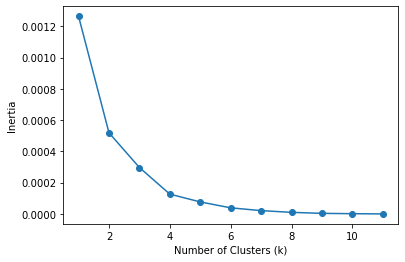

In [9]:

num_clusters = list(range(1,12))
inertias = []

# 각 k별로 모델을 생성하여 inertia를 측정
for i in num_clusters:
    model = KMeans(n_clusters=i, init='k-means++')
    model.fit(geo_df)
    inertias.append(model.inertia_)

# K에 따른 inertia의 변화를 시각화
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel("Inertia")
plt.show()

### K-Means Algorithm

In [10]:
# 
def k_means(geo_df, k):
    geo_df_k = geo_df.copy()
    
    model = KMeans(n_clusters=k, init='k-means++')
    model.fit(geo_df)
    labels = model.predict(geo_df.values)
    geo_df_k['labels'] = labels
    
    return geo_df_k

In [11]:
# 중심과 포인트사이 거리(km)를 dataframe에 추가해주는 함수(label 주어졌을 때 사용)
def distance_center(geo_df_k):
    geo_df_k_c = geo_df_k[['latitude', 'longitude', 'labels']].copy()

    # label의 중심점
    # 인덱스와 label이 일치
    center = geo_df_k_c.groupby('labels')[['latitude', 'longitude']].mean().reset_index('labels')[['latitude', 'longitude']]

    for i in range(geo_df_k_c.shape[0]):
        label = geo_df_k_c.loc[i, 'labels']
        geo_df_k_c.loc[i, "distance_center"] = haversine(geo_df_k_c.loc[i,['latitude', 'longitude']], center.loc[label,['latitude', 'longitude']])

    return geo_df_k_c

In [12]:
# k_means clustering 적용
geo_df_2 = k_means(geo_df, 2)
geo_df_3 = k_means(geo_df, 3)
geo_df_4 = k_means(geo_df, 4)
geo_df_5 = k_means(geo_df, 5)
# 각 클러스터의 중심으로부터 거리 계산
geo_df_2 = distance_center(geo_df_2)
geo_df_3 = distance_center(geo_df_3)
geo_df_4 = distance_center(geo_df_4)
geo_df_5 = distance_center(geo_df_5)

In [13]:
print("각 군집의 중심에서 거리들의 합")
print("K=2 : \n{}\n".format(geo_df_2.groupby('labels')['distance_center'].sum()))
print("K=3 : \n{}\n".format(geo_df_3.groupby('labels')['distance_center'].sum()))
print("K=4 : \n{}\n".format(geo_df_4.groupby('labels')['distance_center'].sum()))
print("K=5 : \n{}\n".format(geo_df_5.groupby('labels')['distance_center'].sum()))

각 군집의 중심에서 거리들의 합
K=2 : 
labels
0    3.103646
1    3.950127
Name: distance_center, dtype: float64

K=3 : 
labels
0    3.950127
1    0.214381
2    0.883400
Name: distance_center, dtype: float64

K=4 : 
labels
0    0.214381
1    1.669239
2    0.883400
3    0.337259
Name: distance_center, dtype: float64

K=5 : 
labels
0    0.337259
1    0.214381
2    0.000000
3    1.669239
4    0.000000
Name: distance_center, dtype: float64



### Visualization

In [14]:
def visual_center(geo_df_k):
    labels = geo_df_k['labels']
    locations = geo_df_k.values 
    m = folium.Map(location = [locations[0][0], locations[0][1]], zoom_start=14)

    # 각 위치 분류별로 색 다르게
    for i in range(geo_df_k.shape[0]):
        if (labels[i] == 0):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'blue')).add_to(m)
        elif (labels[i] == 1):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'red')).add_to(m)
        elif (labels[i] == 2):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'green')).add_to(m)
        elif (labels[i] == 3):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'purple')).add_to(m)
        else:
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'black')).add_to(m)

    # 중심 위치
    center = geo_df_k.groupby('labels')[['latitude', 'longitude']].mean().reset_index('labels')[['latitude', 'longitude']]
    for i in range(len(center)):
        folium.CircleMarker(location=[center.loc[i,'latitude'], center.loc[i, 'longitude']],
                            radius=5,
                            color='red',
                            fill_color='red',
                            draggable = False).add_to(m)
    return m

In [15]:
# k=2
visual_center(geo_df_2)

In [16]:
# k=3
visual_center(geo_df_3)

In [17]:
# k=4
visual_center(geo_df_4)

In [18]:
# k=5
visual_center(geo_df_5)

## 각 군집의 중심으로부터 거리 합이 유사한 Clustering Algorithm

In [19]:
# 군집을 두 개씩 묶는 모든 조합에 대해서 차이에 대한 분산을 구하는 함수
def var_diff(geo_df_k):
    diff_list = []

    combinations = list(itertools.combinations(geo_df_k['labels'].unique(), 2))
    distance_sum = geo_df_k.groupby('labels')['distance_center'].sum()

    for i, j in combinations:
        diff = np.abs(distance_sum[i] - distance_sum[j])
        diff_list.append(diff)

    # print("diff_list : {}".format(diff_list))
    # print("variance : {}".format(statistics.variance(diff_list)))
    return statistics.variance(diff_list)

### 1. 각 point를 다른 군집에 포함시킨 후 비교
- 분산은 작아질 수 있음
- 하지만 이런 경우에는 가장 먼 군집에 포함될수도 있어서 적합하지 않아보임


In [20]:
# 첫번째 점에 대해서 다른 군집에 포함시켜봄
geo_df_3_1 = geo_df_3.copy()
geo_df_3_2 = geo_df_3.copy()

geo_df_3_1.loc[0, 'labels'] = (geo_df_3_1.loc[0, 'labels'] + 1)%3
geo_df_3_2.loc[0, 'labels'] = (geo_df_3_2.loc[0, 'labels'] + 2)%3

geo_df_3_1 = distance_center(geo_df_3_1)
geo_df_3_2 = distance_center(geo_df_3_2)

print(var_diff(geo_df_3))
print(var_diff(geo_df_3_1))
print(var_diff(geo_df_3_2))

2.600234317027273
1.9933779525097264
1.3347860181253492


### 2. 다른 군집 중 가장 가까운 point를 해당 군집에 포함시킨 후 거리 합 차이의 분산 비교

- k개의 군집에 대해 각 군집에서 가장 가까운 point 선정
- 그 point를 해당 군집으로 포함시킨 후 중심으로부터의 거리를 구하고 더한 후 군집간의 차이의 분산 측정
- 기존 군집화 모형과, k개의 시도 중 가장 분산이 작은 군집화 모형 선택

In [22]:
# label 군집이 아닌 point 중 해당 군집에 가장 가까운 point를 해당 군집으로 포함시키는 함수
def near_point_center(geo_df_k, label):
    '''
    input : geo_df_k, 원하는 클러스터(label)
    output : 지정한 클러스터 밖에서 가장 가까운 점을 해당 클러스터에 포함 후 distance_center update한 df
    '''
    geo_df_k_c = geo_df_k.copy()

    # point 변화가 있을수도 있으니 center 새로 정의
    center = geo_df_k_c.groupby('labels')[['latitude', 'longitude']].mean().reset_index('labels')[['latitude', 'longitude']]

    # 군집이 i가 아닌 포인트 중 가장 가까운 포인트의 군집(labels)을 i로 변경
    idx = geo_df_k_c[geo_df_k_c['labels']!=label].index

    geo_df_k_c.loc[:, "distance_other_center"] = np.NAN
    for j in idx:
        geo_df_k_c.loc[j, "distance_other_center"] = haversine(geo_df_k_c.loc[j][[0,1]], center.iloc[label,:])

    geo_df_k_c.loc[np.argmin(geo_df_k_c['distance_other_center']), 'labels'] = label
    del geo_df_k_c['distance_other_center']
    geo_df_k_c = distance_center(geo_df_k_c)
    
    return geo_df_k_c

In [23]:
# 모든 군집에 대해 진행해보고 가장 분산이 작아지는 경우 선택하고 다음 loop 실행
def min_var_center_algorithm(geo_df_k):
    '''
    input : geo_df_k
    output : print - 변경횟수, 최종 결과 Var, return : 최종 dataframe
    '''
    cnt = 0
    while(True):
        var_diff_list = []
        var_diff_list.append(var_diff(geo_df_k))

        k = len(geo_df_k['labels'].unique())
        for label in range(k):
            geo_df_k_c = near_point_center(geo_df_k, label)
            var_diff_list.append(var_diff(geo_df_k_c))

        # print(var_diff_list)
        # print(np.min(var_diff_list))
        # print(np.argmin(var_diff_list))

        if (np.min(var_diff_list) == var_diff_list[0]):
            break
        else:
            geo_df_k = near_point_center(geo_df_k, np.argmin(var_diff_list)-1)
            cnt += 1
            
    print("변경 횟수 : {}".format(cnt))
    print("최종 결과 Var : {}".format(var_diff(geo_df_k)))
    
    return geo_df_k

In [24]:
# geo_df_3, geo_df_4는 k-means 적용한 df인 것 주의!
print("K = 3")
geo_df_3_censum = min_var_center_algorithm(geo_df_3)

print("K = 4")
geo_df_4_censum = min_var_center_algorithm(geo_df_4)

K = 3
변경 횟수 : 1
최종 결과 Var : 0.8533946509771604
K = 4
변경 횟수 : 1
최종 결과 Var : 0.1314404363150546


### Visualization

In [31]:
def visual_center_line(geo_df_k_censum):
    labels = geo_df_k_censum['labels']
    m = folium.Map(location = [locations[0][0], locations[0][1]], zoom_start=14)

    # 각 위치 분류별로 색 다르게
    for i in range(geo_df_k_censum.shape[0]):
        if (labels[i] == 0):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'blue')).add_to(m)
        elif (labels[i] == 1):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'red')).add_to(m)
        elif (labels[i] == 2):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'green')).add_to(m)
        elif (labels[i] == 3):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'purple')).add_to(m)
        else:
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'black')).add_to(m)

    # 중심 위치
    center = geo_df_k_censum.groupby('labels')[['latitude', 'longitude']].mean().reset_index('labels')[['latitude', 'longitude']]
    for i in range(len(center)):
        folium.CircleMarker(location=[center.loc[i,'latitude'], center.loc[i,'longitude']],
                            radius=5,
                            color='red',
                            fill_color='red',
                            draggable = False).add_to(m)

    # 경로 표시
    colors = ['blue', 'red', 'green', 'purple']
    for i in range(len(np.unique(labels))):
        for idx in list(geo_df_k_censum[geo_df_k_censum['labels']==i].index):
            location = []
            location.append([center.loc[i,'latitude'], center.loc[i,'longitude']])
            location.append([geo_df_k_censum.loc[idx, 'latitude'], geo_df_k_censum.loc[idx, 'longitude']])
            folium.PolyLine(locations = location, tooltip = 'Polyline', color = colors[i]).add_to(m)
    return m

In [32]:
# k=3일 때 중심으로부터 거리 비슷한 clustering
visual_center_line(geo_df_3_censum)

In [33]:
# k=4일 때 중심으로부터 거리 비슷한 clustering
visual_center_line(geo_df_4_censum)

## 사용자가 지정한 출발지로부터 클러스터 내 모든 점들을 방문하는 최단거리가 유사하도록 해주는 clustering Algorithm
- k개의 군집에 대해 각 군집에서 가장 가까운 point 선정
- 그 point를 해당 군집으로 포함시킨 후 출발점으로부터 모든 정점 방문하는 거리를 계산 후 최단거리를 찾고 군집간 차이의 분산 측정
- 기존 군집화 모형과, k개의 시도 중 가장 분산이 작은 군집화 모형 선택

In [101]:
geo_df_3_start = geo_df_3.copy()
geo_df_4_start = geo_df_4.copy()

In [102]:
# 각 그룹에서 출발점으로부터 모든 정점을 거쳤을 때 최단거리 산출하는 함수
# 1. 모든 정점 순서 경우 고려 (permutation)
# 2. 그 순서의 거리의 합을 따져서 최단거리 산출
def min_dist_start(geo_df_k, label):
    '''
    Input : df, label(군집)
    Return : 출발점으로부터 군집의 모든 정점을 거쳤을 때 최단거리
    '''
    # 출발점 : 전체 중앙
    # 원하는 지점으로 설정하도록 나중에 함수 만들기
    start = geo_df_k.mean(axis=0)[['latitude', 'longitude']]
    
    # 모든 point 순서 고려 (permutation)
    permutations = list(itertools.permutations(geo_df_k[geo_df_k['labels']==label].index, sum(geo_df_k['labels']==label)))
    
    # 모든 경우 거리 합 계산 후 최소값 산출
    dist_sum_lst = []
    for i in range(len(permutations)):
        # 출발점(도봉구청)과 첫번째 점의 거리 초기화
        dist_sum =  haversine(start, geo_df_k.loc[permutations[i][0], ['latitude', 'longitude']])
        # 순서대로 합 더해줌
        for j in range(len(permutations[0])-1):
            dist_sum += haversine(geo_df_k.loc[permutations[i][j], ['latitude', 'longitude']], geo_df_k.loc[permutations[i][j+1], ['latitude', 'longitude']])
        dist_sum_lst.append(dist_sum)

    # 가장 작은 값 -> 최단거리
    return min(dist_sum_lst)

In [103]:
# 각 그룹에서 출발점으로부터 모든 정점을 거쳤을 때 최단거리인 경우 들린 순서 산출하는 함수
# 1. 모든 정점 순서 경우 고려 (permutation)
# 2. 그 순서의 거리의 합을 따져서 최단거리 산출
def min_dist_start_order(geo_df_k, label):
    '''
    Input : df, label(군집)
    Return : 출발점으로부터 군집의 모든 정점을 거쳤을 때 최단거리인 경우 들린 순서
    '''
    # 출발점 : 전체 중앙
    start = geo_df_k.mean(axis=0)[0:2]
    
    # 모든 point 순서 고려 (permutation)
    permutations = list(itertools.permutations(geo_df_k[geo_df_k['labels']==label].index, sum(geo_df_k['labels']==label)))
    
    # 모든 경우 거리 합 계산 후 최소값 산출
    dist_sum_lst = []
    for i in range(len(permutations)):
        # 출발점(도봉구청)과 첫번째 점의 거리 초기화
        dist_sum =  haversine(start, geo_df_k.loc[permutations[i][0], ['latitude', 'longitude']])
        # 순서대로 합 더해줌
        for j in range(len(permutations[0])-1):
            dist_sum += haversine(geo_df_k.loc[permutations[i][j], ['latitude', 'longitude']], geo_df_k.loc[permutations[i][j+1], ['latitude', 'longitude']])
        dist_sum_lst.append(dist_sum)

    # 가장 작은 값 -> 최단거리일 때 들린 순서
    return permutations[np.argmin(dist_sum_lst)]

In [104]:
# 각 군집마다 최단거리 산출
print("k=3일 때 클러스터 0의 최단거리 : {:.5}km".format(min_dist_start(geo_df_3_start, 0)))
print("k=3일 때 클러스터 1의 최단거리 : {:.5}km".format(min_dist_start(geo_df_3_start, 1)))
print("k=3일 때 클러스터 2의 최단거리 : {:.5}km".format(min_dist_start(geo_df_3_start, 2)))

k=3일 때 클러스터 0의 최단거리 : 2.9427km
k=3일 때 클러스터 1의 최단거리 : 1.7656km
k=3일 때 클러스터 2의 최단거리 : 1.5856km


In [105]:
# 각 군집마다 최단거리일 때 방문 순서
print("k=3일 때 클러스터 0의 최단거리 방문 순서 : {}".format(min_dist_start_order(geo_df_3_start, 0)))
print("k=3일 때 클러스터 1의 최단거리 방문 순서 : {}".format(min_dist_start_order(geo_df_3_start, 1)))
print("k=3일 때 클러스터 2의 최단거리 방문 순서 : {}".format(min_dist_start_order(geo_df_3_start, 2)))

k=3일 때 클러스터 0의 최단거리 방문 순서 : (6, 4, 3, 2, 0, 9, 10)
k=3일 때 클러스터 1의 최단거리 방문 순서 : (1, 5)
k=3일 때 클러스터 2의 최단거리 방문 순서 : (8, 7)


In [106]:
# 각 군집의 출발점으로부터 최단거리끼리 차이의 분산
def start_var_diff(geo_df_k):
    '''
    Input : df
    Return : 각 군집의 출발점으로부터 최단거리 모든 조합 차이의 분산
    '''
    min_distance = []
    for i in geo_df_k['labels'].unique():
        min_distance.append(min_dist_start(geo_df_k, i))

    # k combination 2 : 2개씩 차이의 분산
    combinations = list(itertools.combinations(geo_df_k['labels'].unique(), 2))
    
    diff_list = []
    for i, j in combinations:
        diff = np.abs(min_distance[i] - min_distance[j])
        diff_list.append(diff)

    return statistics.variance(diff_list)

In [107]:
print(start_var_diff(geo_df_3_start))
print(start_var_diff(geo_df_4_start))

0.40206287226710097
0.012484156749749113


In [108]:
# 다른 군집 point 중 해당 군집에 가장 가까운 point를 해당 군집으로 포함시키는 함수
# 중심점에서 가장 가까운 point 해당 군집으로 포함시킴
def near_point_start(geo_df_k, label):
    '''
    Input : df, 변경할 군집
    Return : 군집의 중심에서 다른 군집 point 중 가장 가까운 point 해당 군집으로 변경
    '''
    # 원본 dataframe 변경 방지
    geo_df_k_c = geo_df_k.copy()
    
    center = geo_df_k_c.groupby('labels')[['latitude', 'longitude']].mean().reset_index('labels')[['latitude', 'longitude']]

    # 군집이 i가 아닌 포인트 중 가장 가까운 포인트의 군집(labels)을 i로 변경
    idx = geo_df_k_c[geo_df_k_c['labels']!=label].index

    geo_df_k_c.loc[:, "distance_other_center"] = np.NAN
    for j in idx:
        geo_df_k_c.loc[j, "distance_other_center"] = haversine(geo_df_k_c.loc[j, ['latitude', 'longitude']], center.loc[label,['latitude', 'longitude']])

    geo_df_k_c.loc[np.argmin(geo_df_k_c['distance_other_center']), 'labels'] = label
    del geo_df_k_c['distance_other_center']
    
    return geo_df_k_c

In [109]:
# 모든 군집에 대해 point 추가 진행해보고 가장 분산이 작아지는 경우 선택하고 다음 loop 실행
def min_var_start_algorithm(geo_df_k):
    '''
    Input : df
    Return : print - 변경될 떄 마다 cnt, var, return - 최종 df
    '''
    geo_df_k_c = geo_df_k.copy()
    
    cnt = 0
    # print("초기 Var : {}\n".format(start_var_diff(geo_df_k_c)))

    # 기존 군집화, 각 군집 변화시켜보고 var 비교 후 결정
    while(True):
        var_diff_list = []
        var_diff_list.append(start_var_diff(geo_df_k_c))
        print("Var : {}\n".format(start_var_diff(geo_df_k_c)))
        
        
        k = len(geo_df_k_c['labels'].unique())
        for label in range(k):
            geo_df_k_1 = near_point_start(geo_df_k_c, label)
            var_diff_list.append(start_var_diff(geo_df_k_1))

        if (np.min(var_diff_list) == var_diff_list[0]):
            break
        else:
            geo_df_k_c = near_point_start(geo_df_k_c, np.argmin(var_diff_list)-1)
            cnt += 1
            print("변경 횟수 : {}".format(cnt))
            # print("Var : {}\n".format(start_var_diff(geo_df_k_c)))
            
    print("총 변경 횟수 : {}".format(cnt))
    print("최종 결과 Var : {}".format(start_var_diff(geo_df_k_c)))
    return geo_df_k_c

In [112]:
# check2 1번 뜨는 데 7분 넘게 걸림, 총 10분 35초 걸림
print("K = 3")
geo_df_3_start = min_var_start_algorithm(geo_df_3_start)

K = 3
Var : 0.40206287226710097

변경 횟수 : 1
Var : 0.03588531392700019

변경 횟수 : 2
Var : 0.02405787907663999

총 변경 횟수 : 2
최종 결과 Var : 0.02405787907663999


In [ ]:
print("K = 4")
geo_df_4_start = min_var_start_algorithm(geo_df_4_start)

K = 4
초기 Var : 0.012484156749749113


총 변경 횟수 : 0
최종 결과 Var : 0.012484156749749113


### Visualization

In [97]:
def visual_start_line(geo_df_k_start):
    labels = geo_df_k_start['labels']
    m = folium.Map(location = [locations[0][0], locations[0][1]], zoom_start=14)

    # 각 위치 분류별로 색 다르게
    for i in range(geo_df_k_start.shape[0]):
        if (labels[i] == 0):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'blue')).add_to(m)
        elif (labels[i] == 1):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'red')).add_to(m)
        elif (labels[i] == 2):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'green')).add_to(m)
        elif (labels[i] == 3):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'purple')).add_to(m)
        else:
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'black')).add_to(m)

    # 중심 위치
    start = geo_df_k_start.mean(axis=0)[['latitude', 'longitude']]
    folium.CircleMarker(location=[start['latitude'], start['longitude']],
                            radius=5,
                            color='red',
                            fill_color='red',
                            draggable = False).add_to(m)

    # 경로 표시
    colors = ['blue', 'red', 'green', 'purple']
    for i in np.unique(labels):
        orders = min_dist_start_order(geo_df_k_start, i)
        location = []
        for order in orders:
            location.append([geo_df_k_start.loc[order, 'latitude'], geo_df_k_start.loc[order, 'longitude']])
        location.insert(0, [start['latitude'], start['longitude']])

        folium.PolyLine(locations = location, tooltip = 'Polyline', color = colors[i]).add_to(m)
    return m

In [113]:
# k=3 일 때 출발점으로부터 최단거리로 방문하는 경로 시각화
visual_start_line(geo_df_3_start)

In [69]:
# k=4 일 때 출발점으로부터 최단거리로 방문하는 경로 시각화
visual_start_line(geo_df_4_start)